## **Deep Learning Made Easy**

----

Author:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>.


<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

This notebook is related to the image classification problem based on the classical CIFAR-10 database. Hovewer, its goal is to address performance bottlenecks of the network/model via the TensorBoard Plugin with PyTorch Profiler. Hence, it will not cover the classification task completely. It uses two neural networks to address this problem: ```CNN3L``` by <a href="https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118">Nutan</a> and ```LeNet-5``` presented in the <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html">*Training a Classifier*</a> PyTorch tutorial. 





In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from prettytable import PrettyTable
import torch.profiler
import torch.utils.data

In [ ]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

## **Define important variables**
----

Here, we set the number of classes, some hyper-parameters, and the number of images of the training dataset to consider in the performance analysis.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Hyper-parameters
batch_size = 4 # The size of input data took for one iteration
lr = 1e-3 # Learning rate

# Number of images: profiling
num_images = 10000 # Number of images to consider
max_batches = num_images/batch_size # Maximum number of batches
print('Maximum number of batches: ', int(max_batches))

Maximum number of batches:  2500


## **CIFAR-10 dataset**
----

Downloading and handling the CIFAR-10 dataset. As per the PyTorch tutorial, "the output of torchvision datasets are PILImage images of range [0, 1]. We transform them to tensors of normalized range [-1, 1]." This normalisation is done by ```transforms.Normalize```.



In [ ]:
# We only need the training dataset in this analysis.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

print('#'*20)
print('Training dataset: ', train_set)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Device is:  cuda:0
####################
Training dataset:  Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## **Looking at the training dataset**

----

Just taking a quick look at the training dataset.



One batch - training dataset: torch.Size([4, 3, 32, 32])

Each image of the batch:
Image: 0 - Input shape: torch.Size([3, 32, 32]) - Class: 3
Image: 1 - Input shape: torch.Size([3, 32, 32]) - Class: 4
Image: 2 - Input shape: torch.Size([3, 32, 32]) - Class: 5
Image: 3 - Input shape: torch.Size([3, 32, 32]) - Class: 8
The "image" itself:  tensor([[[ 0.4824,  0.5373,  0.7412,  ...,  0.9765,  0.9686,  0.9765],
         [ 0.5059,  0.7255,  0.8118,  ...,  1.0000,  1.0000,  0.9922],
         [ 0.7882,  0.8353,  0.8980,  ...,  0.9843,  0.9765,  0.9686],
         ...,
         [-0.9059, -0.8902, -0.8745,  ..., -0.9373, -0.9451, -0.9451],
         [-0.9059, -0.8667, -0.8510,  ..., -0.9294, -0.9451, -0.9451],
         [-0.9059, -0.8667, -0.8745,  ..., -0.9373, -0.9451, -0.9451]],

        [[ 0.3725,  0.4353,  0.6314,  ...,  0.8431,  0.8510,  0.8745],
         [ 0.3961,  0.6157,  0.7020,  ...,  0.8745,  0.8824,  0.8980],
         [ 0.6863,  0.7333,  0.7961,  ...,  0.8667,  0.8745,  0.8824],
     

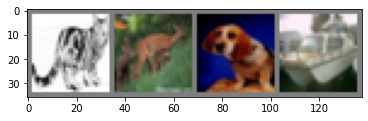

  cat -  deer -   dog -  ship


In [ ]:
# Just visualising some images
def visualise_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch: training dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('One batch - training dataset:', images.shape)

print('\nEach image of the batch:')
for i in range(labels.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, images[i].shape, labels[i]))
  if i == (labels.shape[0]-1):
    print('The "image" itself: ', images[i])

# Show images
visualise_images(torchvision.utils.make_grid(images))
# Print labels
print(' - '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## **Neural networks**

----

We use two neural networks in this analysis. The first network is ```CNN3L``` which is considered a shallow neural network (SNN) because it has two hidden (convolutional) layers and the output layer (traditionally, a model/network is considered shallow when it has one or two hidden layers).

<br>

The second network is the classical <a href="https://ieeexplore.ieee.org/document/726791">```LeNet-5```</a> DNN with five layers where four are hidden ones.



In [ ]:
class CNN3L(nn.Module):
    def __init__(self, num_clas):
        super(CNN3L, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # Fully-connected layer
        self.out = nn.Linear(32 * 5 * 5, num_clas)
    def forward(self, x):
        #print('x size 0: ', x.size())
        x = self.conv1(x)
        #print('x size 1: ', x.size())
        x = self.conv2(x)
        #print('x size 2: ', x.size())
        x = x.view(x.size(0), -1) 
        #print('x size 3: ', x.size())
        output = self.out(x)
        #print('output: ', output.size())
        return output   

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_clas):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_clas)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## **Select the model**

----

Now, we can select one of the models/networks.



In [ ]:
opt = input("Enter your choice:")
if opt =='1':
  net = CNN3L(num_classes)
  opt_name = 'CNN3L'
  print("You selected CNN3L!")
elif opt =='2':
  net = LeNet5(num_classes)
  opt_name = 'LeNet-5'
  print("You selected LeNet-5!")
else:
  print("Invalid Option!")

if torch.cuda.is_available():
   net.to(device)

Enter your choice:1
You selected CNN3L!


## **Define loss function and optimiser**

----

The <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. The learning rate has already been defined. We also check the number of trainable parameters.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    1200    |
|  conv1.0.bias  |     16     |
| conv2.0.weight |   12800    |
|  conv2.0.bias  |     32     |
|   out.weight   |    8000    |
|    out.bias    |     10     |
+----------------+------------+
Total trainable params: 22058
Checking trainable parameters: 22058


## **Training phase**

----

Here, we starting training the model (```net.train()``` and function ```train_model(data)```).



In [ ]:
net.train() 
def train_model(data):
  images, labels = Variable(data[0]).to(device), Variable(data[1]).to(device) 
      
  optimizer.zero_grad()
  with torch.set_grad_enabled(True):
    outputs = net(images)
    _, preds = torch.max(outputs, 1)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()  

## **Use the PyTorch Profiler**
----

Here, we use the PyTorch Profiler to record execution events. After running this notebook, the results will be saved under ```./log/xyz``` folder.



In [ ]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/cifar_'+opt_name+'_bat_'+str(batch_size)),
        record_shapes=True,
        with_stack=True
) as prof:
    for num_batch, batch_data in enumerate(train_loader):
        print('Batch number:', num_batch)
        if num_batch >= int(max_batches): 
            break
        train_model(batch_data)
        prof.step()  # Need to call this at the end of each step to notify profiler of steps' boundary.

Batch number: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Batch number: 19
Batch number: 20
Batch number: 21
Batch number: 22
Batch number: 23
Batch number: 24
Batch number: 25
Batch number: 26
Batch number: 27
Batch number: 28
Batch number: 29
Batch number: 30
Batch number: 31
Batch number: 32
Batch number: 33
Batch number: 34
Batch number: 35
Batch number: 36
Batch number: 37
Batch number: 38
Batch number: 39
Batch number: 40
Batch number: 41
Batch number: 42
Batch number: 43
Batch number: 44
Batch number: 45
Batch number: 46
Batch number: 47
Batch number: 48
Batch number: 49
Batch number: 50
Batch number: 51
Batch number: 52
Batch number: 53
Batch number: 54
Batch number: 55
Batch number: 56
Batch number: 57
Batch number: 58
Batch number: 59
Batch 

## **Run TensorBoard**
----

In order to visualise the results and check the performance bottlenecks of the model, proceed as follows as per the <a href="https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html">PyTorch tutorial </a>:



1. download the results in ```./log/xyz``` to your computer; 
2. install PyTorch Profiler TensorBoard Plugin (```pip install torch_tb_profiler```);
3. launch the TensorBoard (```tensorboard --logdir=./log```);
4. open the TensorBoard profile URL in Google Chrome browser (```http://localhost:6006/#pytorch_profiler```). 

